In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
# random_seed = 42
do_training = True
plot_train_curve = True 
save_synthetic_samples = True
save_model = False
max_epochs = 500
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, max_epochs+1, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'chamfer'
do_wgan = False
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
special_tag = 'turbo_latent'

Give me the class type.
chair
Give me bneck_size.
128


In [5]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_experiment_tag, ae_loss, 'bneck', str(b_neck)])

if special_tag is not None:
    experiment_tag += '_' + special_tag

print experiment_tag

l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128_turbo_latent


In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_data = in_data['train']

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [7]:
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/', gan_tag, experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128_turbo_latent'

In [8]:
# Load Auto-Encoder
ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))
saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

TypeError: ones_initializer() got multiple values for keyword argument 'dtype'

In [ ]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [ ]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = b_neck
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [14]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                    beta=beta                    
                   )
                    # latent_code_discriminator, , latent_code_generator,
#                     gen_kwargs={'layer_sizes': [64, 128], 'b_norm': False}, 
#                     disc_kwargs={'layer_sizes': [512, 1024], 'b_norm': False})
else:
    beta = 0.5
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim,
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                    beta=beta
                   )

1 (0.71512524096862129, 0.87149551795876545)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


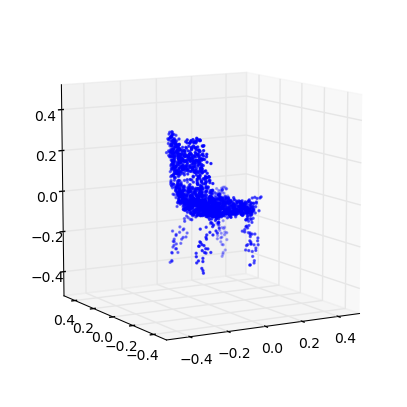

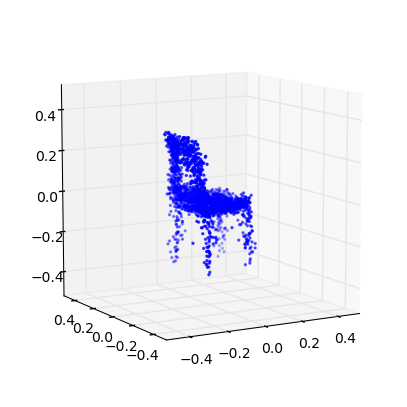

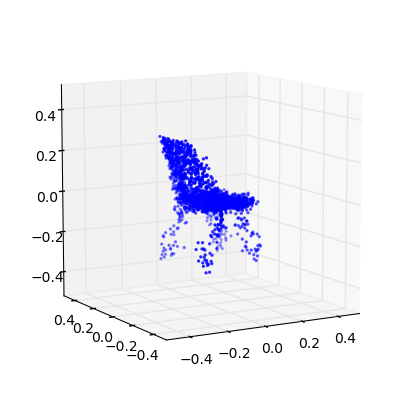

2 (0.29574254854865695, 1.6839392444361811)
3 (0.41495626698369564, 1.8486135368761809)
4 (1.0820095181465148, 1.2648590243381002)
5 (1.4193532238835873, 0.99964320400486817)


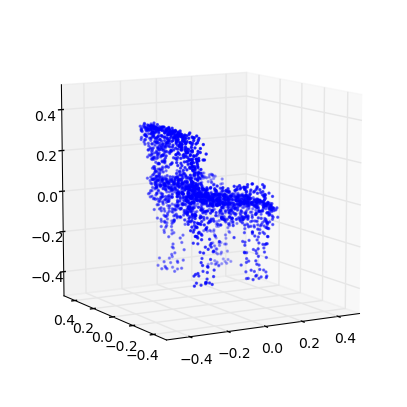

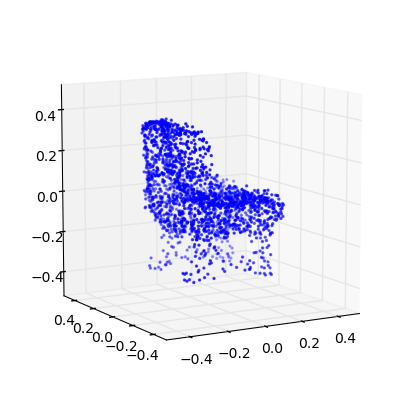

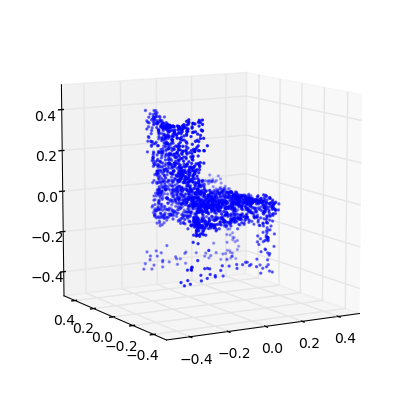

6 (1.2839013275892839, 1.008495777586232)
7 (1.0647321307140849, 1.1334641280381577)
8 (0.86144525745640632, 1.3068915190904036)
9 (0.77612790335779602, 1.3936910618906435)
10 (0.8006270139113717, 1.3492984087570854)


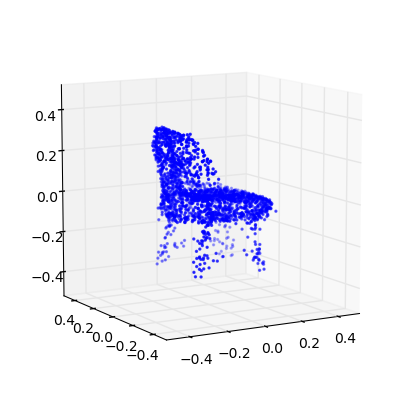

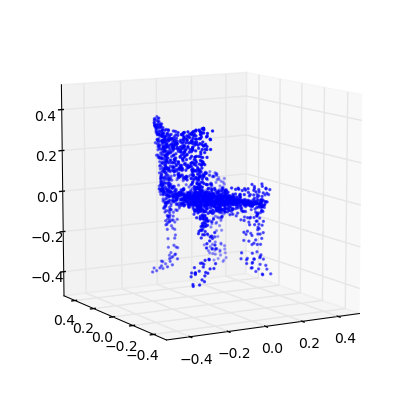

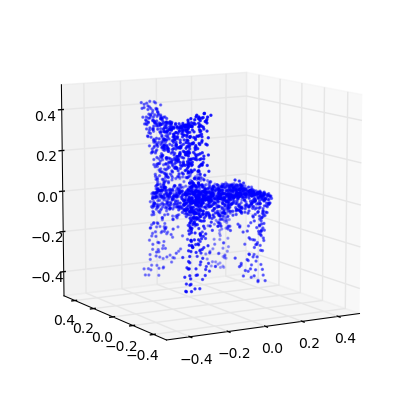

11 (0.85113086907759961, 1.2111766981041949)
12 (0.84549095060514368, 1.1612425534621529)
13 (0.86662192655646286, 1.1845049116922461)
14 (0.93515057771102239, 1.2026210333990015)
15 (1.0298405864964362, 1.1656236959540325)
16 (1.0909284954485685, 1.1002915211345838)
17 (1.1616848862689475, 1.0308353729870008)
18 (1.2028765170470528, 0.974766004603842)
19 (1.2407692038494609, 0.91498031668041069)
20 (1.2779784067817357, 0.87464234258817586)
21 (1.2955808141957159, 0.84260034509327097)
22 (1.2946859898774521, 0.83502336740493777)
23 (1.2808032170585963, 0.83611846799435818)
24 (1.2781216901281605, 0.83408805391062857)
25 (1.2925538881965306, 0.8242535145386406)
26 (1.3013342950655067, 0.8137867129367331)
27 (1.2869069203086521, 0.81584283113479616)
28 (1.2872500792793606, 0.81711780454801475)
29 (1.2968355583107989, 0.81056459727494612)
30 (1.2966193935145502, 0.80321567058563237)
31 (1.2979821422825688, 0.79800281887469082)
32 (1.2960892241934072, 0.79414711568666541)
33 (1.29411625551

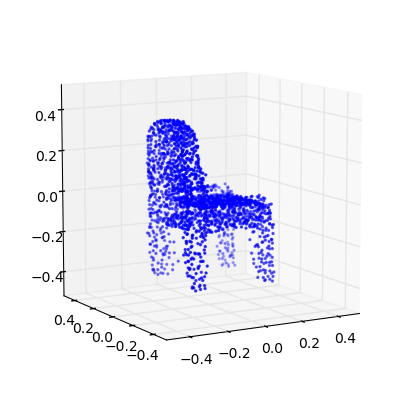

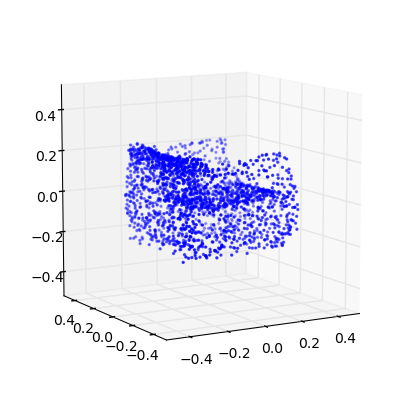

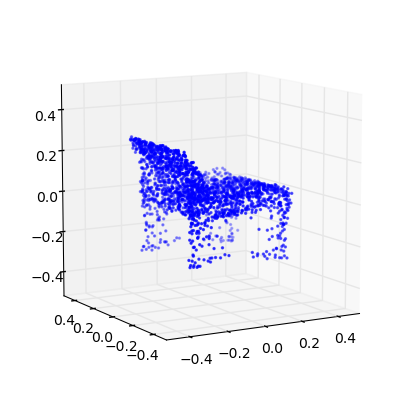

51 (1.2512647048286769, 0.83443028823189114)
52 (1.2456411745237268, 0.84544062199799908)
53 (1.2405387712561566, 0.84613907544509226)
54 (1.2428313483362612, 0.84971695464590324)
55 (1.2477664170057878, 0.85023276287576421)
56 (1.2465762967648713, 0.8420837547468103)
57 (1.2458895133889241, 0.84489888937576962)
58 (1.2544822102007658, 0.84495147259339043)
59 (1.2503261576528135, 0.84763637781143186)
60 (1.2529404609099679, 0.84067825286284736)
61 (1.2588158773339313, 0.83405644893646236)
62 (1.2593401338743127, 0.84077167251835694)
63 (1.2566599296486896, 0.83996563735215557)
64 (1.2596390236978945, 0.84305426400640737)
65 (1.2559789118559463, 0.83420745030693388)
66 (1.2648216641467551, 0.83551033061483637)
67 (1.2583592217901478, 0.84017172274382224)
68 (1.2599849949712338, 0.83506596347560058)
69 (1.2491278606912364, 0.84132902570392776)
70 (1.2521813475567363, 0.83832250937171604)
71 (1.2471499899159306, 0.8428088457688041)
72 (1.2475239525670592, 0.84009072884269387)
73 (1.245746

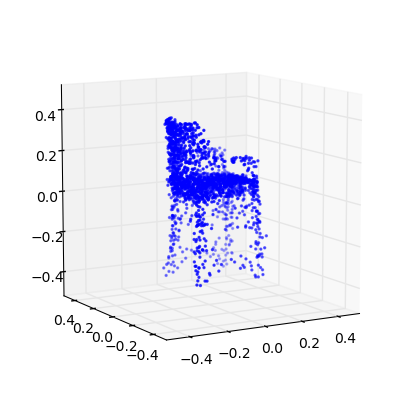

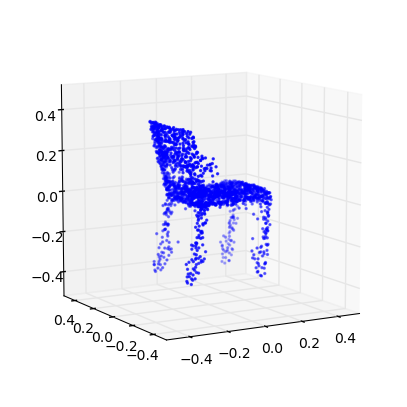

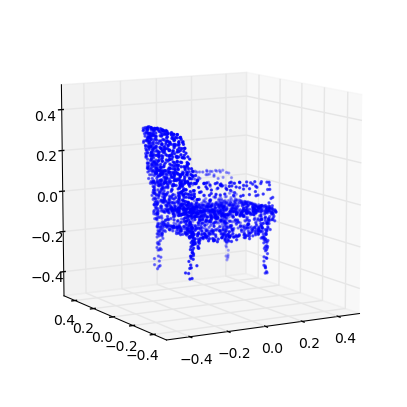

101 (1.2295472145080566, 0.85716597360113389)
102 (1.2310754433922146, 0.85686680752298106)
103 (1.2279097069864688, 0.86008690854777459)
104 (1.2202964523564215, 0.86543873341187183)
105 (1.2211017567178477, 0.8624672459519428)
106 (1.2222544400588327, 0.86753586167874541)
107 (1.2186081471650496, 0.86194769092228096)
108 (1.2179588763610176, 0.8701150578001271)
109 (1.2085087703621906, 0.87124400501665866)
110 (1.2136781651040782, 0.87543387413024898)
111 (1.2083425210869831, 0.874533458378004)
112 (1.2054240019425102, 0.87904567303864856)
113 (1.1995221220928689, 0.88145113146823384)
114 (1.1981663506963978, 0.88906950173170674)
115 (1.1974457066992055, 0.88719359739967019)
116 (1.1953309701836627, 0.88800493945246162)
117 (1.1962355188701463, 0.89067423084507813)
118 (1.1995145414186561, 0.88834449415621553)
119 (1.1953884259514187, 0.8888730422310207)
120 (1.1896041745724886, 0.8977311481600222)
121 (1.1848947514658388, 0.90507242990576697)
122 (1.1883698411609815, 0.9003938763037

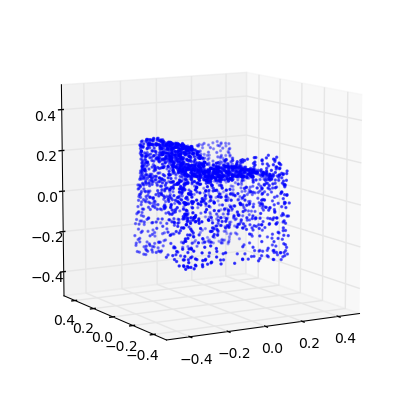

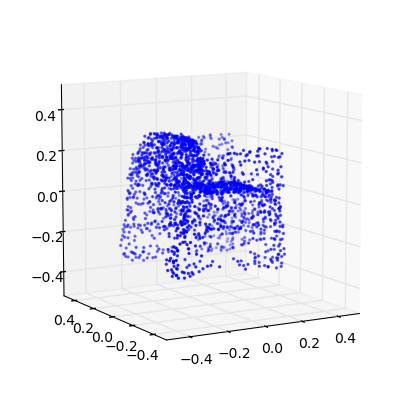

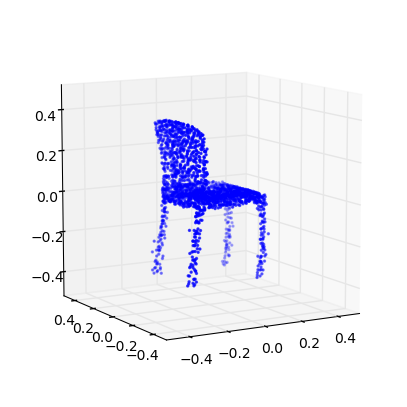

151 (1.1580433928448222, 0.93950874131658801)
152 (1.1508696566457335, 0.94693664882494055)
153 (1.1544660112132197, 0.94601907522782036)
154 (1.1485340636709462, 0.94414301385050237)
155 (1.1438590816829515, 0.94912460420442668)
156 (1.1521673881489298, 0.94826357623805169)
157 (1.14663259672082, 0.94734539260034978)
158 (1.1433245731436688, 0.95530943352243169)
159 (1.15234724542369, 0.94858723619709839)
160 (1.1438283256862474, 0.95402181355849558)
161 (1.1430946277535481, 0.95174884796142578)
162 (1.1494235194247702, 0.95302616979764854)
163 (1.1470615526904231, 0.95709440915480903)
164 (1.1412446068680804, 0.96092269472453906)
165 (1.1433434268702631, 0.95552370755568794)
166 (1.1484690697296807, 0.95518452291903289)
167 (1.1480355449344801, 0.95429186872814009)
168 (1.1486635156299756, 0.96113450164380276)
169 (1.1514720553937166, 0.95715055206547617)
170 (1.1494048750918844, 0.95841181122738384)
171 (1.1436460940734199, 0.95960264568743503)
172 (1.1438087079835975, 0.95965978114

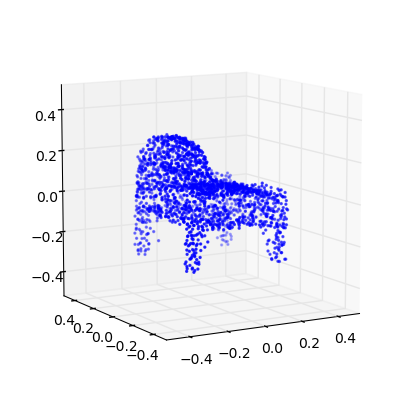

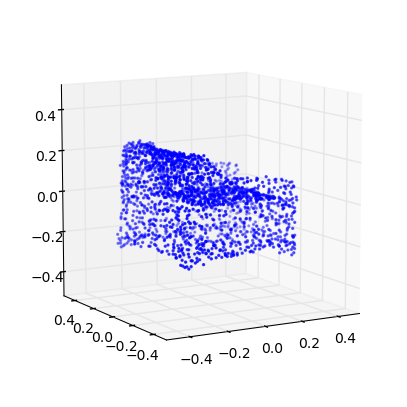

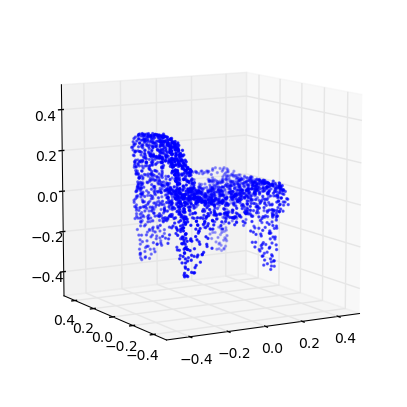

201 (1.1178063537763512, 0.99216654404349947)
202 (1.1157030872676683, 0.9905491238055022)
203 (1.1181379846904589, 0.99260314495667168)
204 (1.1175567321155382, 0.99394557683364204)
205 (1.110428816339244, 1.0000912816628167)
206 (1.1116416640903639, 0.99882302439731097)
207 (1.1114322465399038, 0.99249873886937678)
208 (1.1181235914644987, 0.99278623850449277)
209 (1.1195405628370203, 0.99114349458528606)
210 (1.1129042096759962, 0.99591416846150937)
211 (1.1096697548161383, 1.0001221791557644)
212 (1.1127154417659926, 1.001980896099754)
213 (1.1170565962791443, 0.99709466540295144)
214 (1.1197962595068891, 0.99441709518432619)
215 (1.1025169559147048, 1.0061955394952193)
216 (1.1167858014936032, 0.99718123104261314)
217 (1.1096708665723387, 0.99921787925388506)
218 (1.1137177197829538, 1.0014521225639013)
219 (1.1100881783858589, 1.0006093781927357)
220 (1.1021465218585471, 1.0070659450862718)
221 (1.099484666534092, 1.0097313699514969)
222 (1.109648504982824, 1.0058020835337431)
22

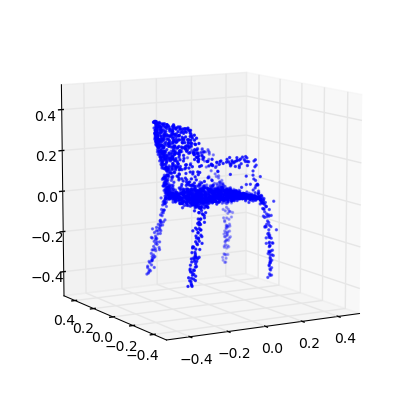

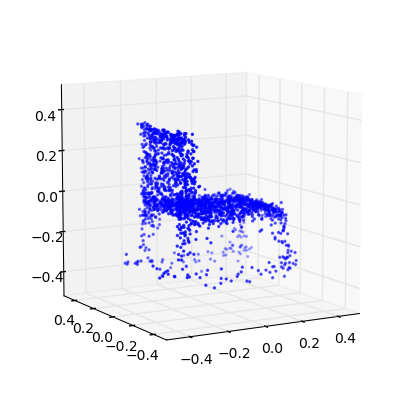

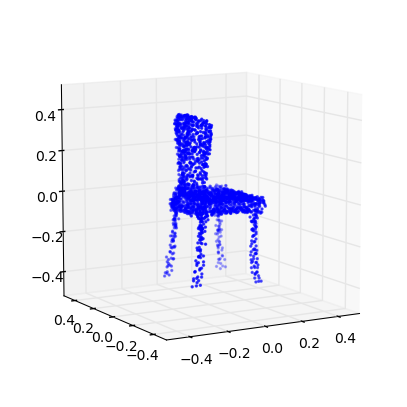

251 (1.087538999059926, 1.03179378716842)
252 (1.0893134225969729, 1.0338871847028317)
253 (1.0856073721595432, 1.0323002053343731)
254 (1.0803018357442773, 1.0354968874350838)
255 (1.0899422526359559, 1.0319271113561548)
256 (1.0810022183086561, 1.0380885699520941)
257 (1.0838581567225249, 1.039213163956352)
258 (1.0783621077952177, 1.0428652094758075)
259 (1.0822105786074763, 1.0389250480610392)
260 (1.0876698514689569, 1.0291358227315157)
261 (1.0820441619209622, 1.035471835343734)
262 (1.0744749520135963, 1.0421106613200644)
263 (1.0900909931763358, 1.0381325239720551)
264 (1.075824853130009, 1.0442996450092481)
265 (1.0749231193376625, 1.0445182307906773)
266 (1.0788758055023524, 1.0377798215202663)
267 (1.0810909919116809, 1.0451319196949835)
268 (1.0770000250443168, 1.0436144160187764)
269 (1.0752524360366489, 1.040684483880582)
270 (1.0812145145043084, 1.0460185507069464)
271 (1.0714582966721575, 1.0521434239719225)
272 (1.0711113971212636, 1.0500503664431364)
273 (1.0672159894

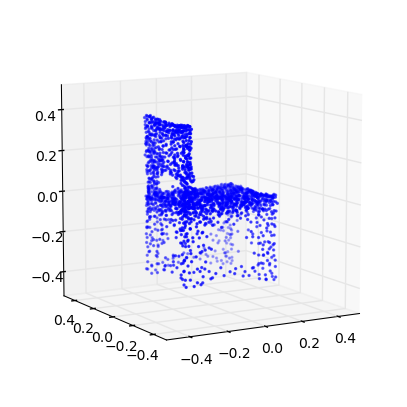

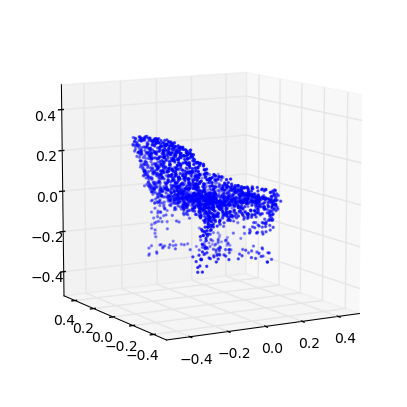

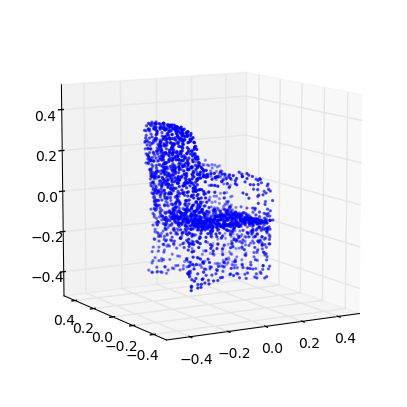

301 (1.0397607917371003, 1.0893857489461485)
302 (1.0393452644348145, 1.0885398574497389)
303 (1.0435029594794563, 1.096141250755476)
304 (1.0432054094646288, 1.0841968811076621)
305 (1.0412013105724169, 1.0842544172121131)
306 (1.0420936460080354, 1.0902413015780241)
307 (1.0426702867383542, 1.0876803714296093)
308 (1.0324614716612774, 1.0986598647159078)
309 (1.0412423543308091, 1.0919956513073132)
310 (1.0325876505478568, 1.0966638559880464)
311 (1.0402505206025165, 1.09627605676651)
312 (1.0330593290536301, 1.1004245011702827)
313 (1.0300271863522736, 1.0974942938141201)
314 (1.0353472497152245, 1.0966842164164003)
315 (1.0352274744406991, 1.0938416926757148)
316 (1.035328878008801, 1.0916685648586439)
317 (1.0278205824934918, 1.1039014717806941)
318 (1.0315546927244768, 1.1003913905309595)
319 (1.0239700846050097, 1.1020931793295818)
320 (1.0251985218213953, 1.1057232530220695)
321 (1.0270091347072436, 1.1051338936971582)
322 (1.0327755554862645, 1.1046782835670139)
323 (1.0230677

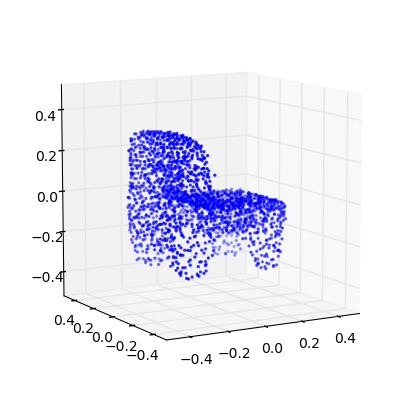

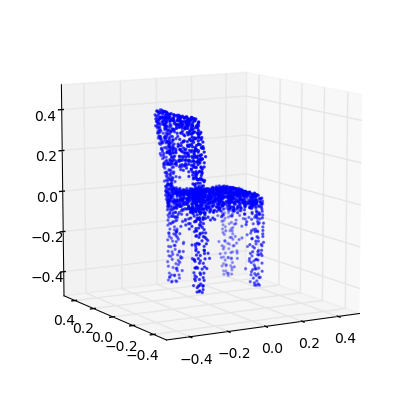

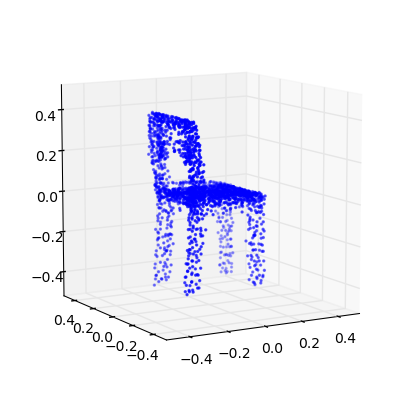

351 (1.0042287577753481, 1.138324903405231)
352 (0.99439829432446025, 1.141864361970321)
353 (0.99935997465382453, 1.1374936331873355)
354 (0.99714845937231311, 1.146777611711751)
355 (1.0047991363898567, 1.1447212784186653)
356 (0.99504798650741577, 1.1469023834104124)
357 (0.99214082645333335, 1.1438578419063403)
358 (1.007411103144936, 1.1396687694217849)
359 (0.99366136115530268, 1.1412273256675056)
360 (0.99367974633755896, 1.1466165081314419)
361 (0.99891433404839558, 1.1537810113119042)
362 (0.9939601468003314, 1.1478405869525412)
363 (0.99260975744413293, 1.1536730465681657)
364 (0.98715778744739036, 1.1544997868330582)
365 (0.99502718552299163, 1.1413201363190362)
366 (0.99165672633958901, 1.1499496019404867)
367 (0.99455890603687447, 1.1527059285537056)
368 (0.99431494267090503, 1.1465459180914837)
369 (0.98929639380911127, 1.1551019497539685)
370 (0.99721989009691325, 1.1474549630413884)
371 (0.98516361143278042, 1.1547158422677413)
372 (0.98634170449298364, 1.15451962066733

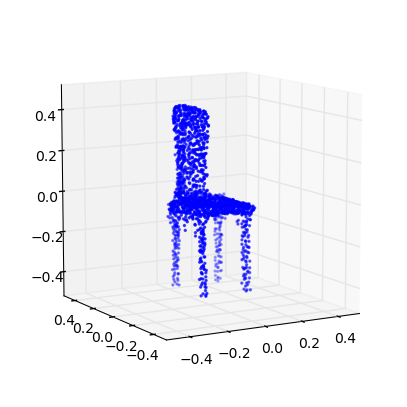

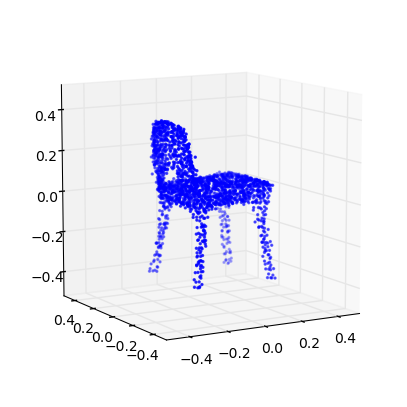

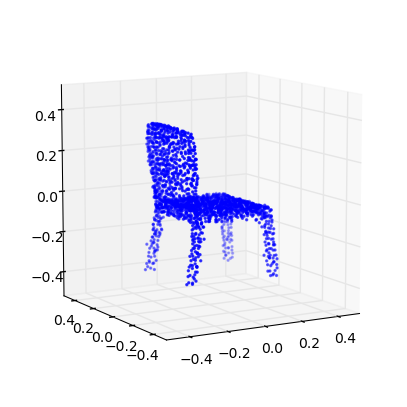

401 (0.96721251321875534, 1.1931975784509079)
402 (0.96726532759873762, 1.1837488003399061)
403 (0.9629061600436335, 1.1887988448143005)
404 (0.971160612417304, 1.1901789105456808)
405 (0.96582189487374348, 1.1884794084922128)
406 (0.96868484279383782, 1.1922014236450196)
407 (0.96490126329919568, 1.1859788438548213)
408 (0.95820100722105606, 1.1981418920599896)
409 (0.96327975988388059, 1.1938881651214932)
410 (0.9579381419264752, 1.1905986723692521)
411 (0.9499996967937635, 1.2069375753402709)
412 (0.96634859157645181, 1.1989588996638423)
413 (0.9576118619545646, 1.202451487209486)
414 (0.95393756887187131, 1.2073847231657608)
415 (0.9628004193305969, 1.1942896967348846)
416 (0.96253366314846533, 1.1968883623247561)
417 (0.95261118256527444, 1.2005517130312713)
418 (0.96246490841326504, 1.1955787658691406)
419 (0.94937201323716536, 1.2069620163544366)
420 (0.9533498276834903, 1.2119198690290036)
421 (0.9492627942043802, 1.2013596244480298)
422 (0.95928380748499997, 1.2061016067214634

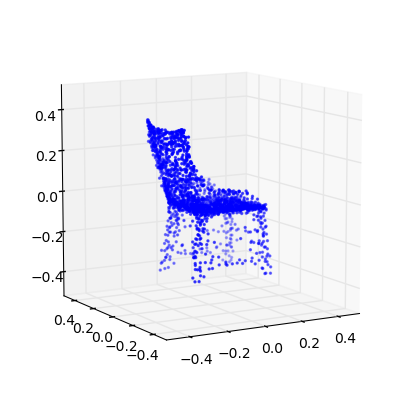

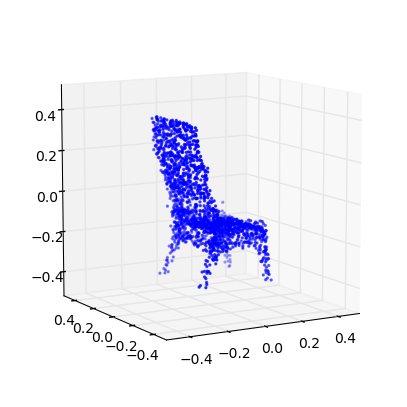

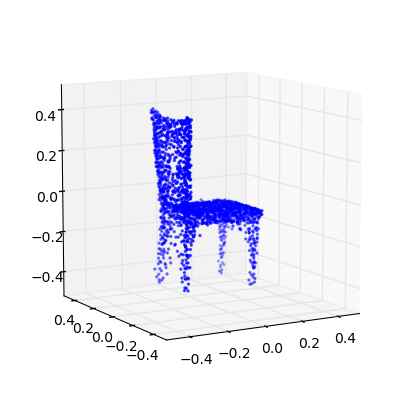

451 (0.92837077431056814, 1.2392344277838001)
452 (0.93495787226635474, 1.2382861080376999)
453 (0.93498413096303523, 1.2289433629616446)
454 (0.93714862491773521, 1.2273871665415557)
455 (0.93097350441891213, 1.2317307321921638)
456 (0.93013470380202579, 1.2436713026917499)
457 (0.93601702814516818, 1.2386732531630475)
458 (0.93245305652203769, 1.2378286278766135)
459 (0.92726499827011777, 1.2417275433954986)
460 (0.93739652737327239, 1.2444141735201297)
461 (0.92536935184312907, 1.2461839427118715)
462 (0.92154972086782039, 1.2503657916317816)
463 (0.92438126387803454, 1.2505006292591925)
464 (0.9281601900639741, 1.2468553278757177)
465 (0.93066370953684263, 1.2420861389326012)
466 (0.91962699941966841, 1.2536862902019335)
467 (0.92736026515131409, 1.2466843485832215)
468 (0.92952169128086259, 1.2410551915998045)
469 (0.91861210180365516, 1.2472611582797506)
470 (0.92608326880828196, 1.2539515381274016)
471 (0.92064557852952378, 1.2503335859464562)
472 (0.92305809207584544, 1.2520860

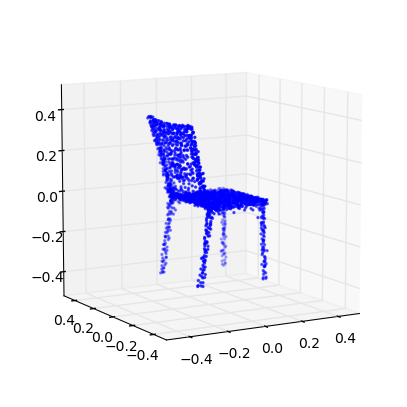

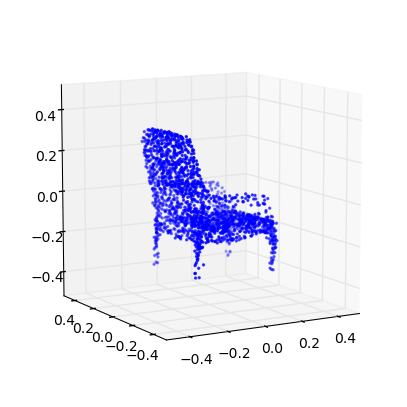

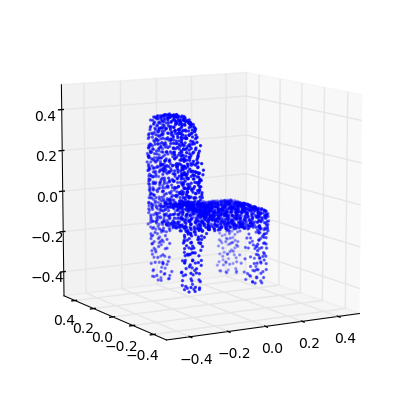

In [15]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
        if save_synthetic_samples and epoch in saver_step:
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)

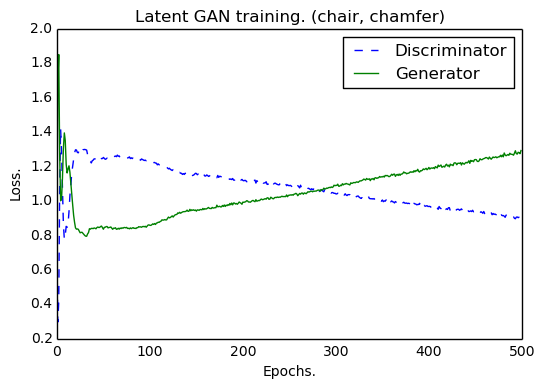

In [16]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')